<a href="https://colab.research.google.com/github/andradhf/water-level-anomaly-detection/blob/main/Isolation_Forest_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Algorithm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Water_level_dataset/water_level_dataset.csv', index_col=0)
df_test = pd.read_csv('/content/drive/MyDrive/Water_level_dataset/water_level_label.csv', index_col=0)

In [4]:
df.head()

,water_level
timestamp,
2023-01-01 00:40:00,0.495016
2023-01-01 01:25:00,0.547955
2023-01-01 02:10:00,0.652855
2023-01-01 02:55:01,0.728848
2023-01-01 03:40:00,0.802187


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11677 entries, 2023-01-01 00:40:00 to 2023-12-31 23:55:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   water_level  11677 non-null  float64
dtypes: float64(1)
memory usage: 182.5+ KB


In [6]:
df.describe()

,water_level
count,11677.000000
mean,0.686107
std,0.265425
min,0.013859
25%,0.490089
50%,0.688873
75%,0.886564
max,1.448410


In [7]:
df.shape

(11677, 1)

##Cleaning Data

In [8]:
print('Duplicated:', df.duplicated().sum())

Duplicated: 318


In [9]:
df.shape

(11677, 1)

In [10]:
df = df.drop_duplicates()
print('Duplicated:', df.duplicated().sum())
df.shape

Duplicated: 0


(11359, 1)

In [11]:
df.isnull().sum()

,0
water_level,0


##Exploratory Data Analysis(EDA)

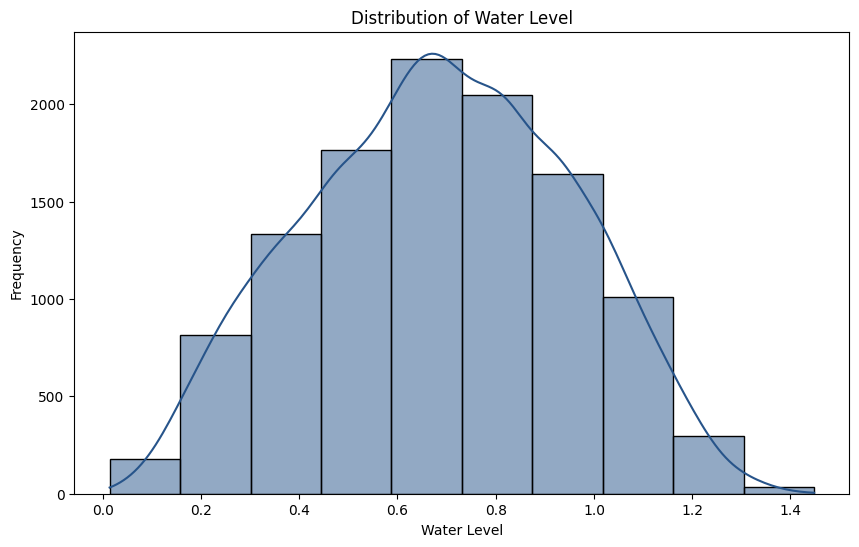

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='water_level', bins=10, kde=True, color='#27548A')

plt.title('Distribution of Water Level')
plt.xlabel('Water Level')
plt.ylabel('Frequency')
plt.show()

In [13]:
df.skew()

,0
water_level,-0.042733


##Data Preparation

In [14]:
df_test.head()

,water_level,label
timestamp,,
2024-12-01 02:55:00,0.609146,0
2024-12-01 03:30:00,0.716856,0
2024-12-01 04:05:00,0.793186,0
2024-12-01 04:40:00,0.887867,0
2024-12-01 05:15:00,1.011236,0


In [15]:
df_test = df_test.drop(columns=['label'])
df_test

,water_level
timestamp,
2024-12-01 02:55:00,0.609146
2024-12-01 03:30:00,0.716856
2024-12-01 04:05:00,0.793186
2024-12-01 04:40:00,0.887867
2024-12-01 05:15:00,1.011236
...,...
2025-01-31 16:35:00,0.602495
2025-01-31 16:55:00,0.532871
2025-01-31 17:15:00,0.493481


In [16]:
df['rolling_avg'] = df['water_level'].rolling(window=48).mean()
df_test['rolling_avg'] = df_test['water_level'].rolling(window=48).mean()

In [ ]:
df['rolling_std'] = df['water_level'].rolling(window=48).std()
df_test['rolling_std'] = df_test['water_level'].rolling(window=48).std()

In [ ]:
df['change_rate'] = df['water_level'].diff()
df_test['change_rate'] = df_test['water_level'].diff()

In [17]:
df = df.dropna()
df_test = df_test.dropna()

In [18]:
df.head()

,water_level,rolling_avg
timestamp,,
2023-01-02 11:55:00,0.720879,0.686247
2023-01-02 12:40:00,0.642118,0.689312
2023-01-02 13:25:00,0.512680,0.688577
2023-01-02 14:10:00,0.480217,0.684980
2023-01-02 14:55:00,0.380310,0.677719


In [19]:
df_test.head()

,water_level,rolling_avg
timestamp,,
2024-12-02 06:20:00,1.121786,0.760128
2024-12-02 06:55:00,1.180969,0.772041
2024-12-02 07:30:01,1.251879,0.783188
2024-12-02 08:05:00,1.310207,0.793959
2024-12-02 08:40:01,1.284807,0.802229


In [20]:
feature = df[['water_level','rolling_avg' ]]

In [ ]:
df_test = df_test.drop(columns=[ 'rolling_std'])

In [ ]:
"""scaler = StandardScaler()
feature = scaler.fit_transform(x_train)
df_test = scaler.transform(df_test)"""

In [21]:
feature.head()

,water_level,rolling_avg
timestamp,,
2023-01-02 11:55:00,0.720879,0.686247
2023-01-02 12:40:00,0.642118,0.689312
2023-01-02 13:25:00,0.512680,0.688577
2023-01-02 14:10:00,0.480217,0.684980
2023-01-02 14:55:00,0.380310,0.677719


##Model Building

In [101]:
#Hyperparameters
n_estimators = 1024
contamination = 0.04
sample_size = 32

In [102]:
iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, max_samples=sample_size, random_state=42)
iso_forest.fit(feature)

IsolationForest(contamination=0.04, max_samples=32, n_estimators=1024,
                random_state=42)

In [103]:
train_data = pd.DataFrame(feature, columns=['water_level'])
train_data['anomaly_score'] = iso_forest.decision_function(feature)
train_data['anomaly'] = iso_forest.predict(feature)

train_data['anomaly'].head(10)

,anomaly
timestamp,
2023-01-02 11:55:00,1
2023-01-02 12:40:00,1
2023-01-02 13:25:00,1
2023-01-02 14:10:00,1
2023-01-02 14:55:00,1
2023-01-02 15:40:00,1
2023-01-02 16:25:00,1
2023-01-02 17:10:00,1
2023-01-02 17:55:00,1


In [104]:
train_anomalies = train_data.loc[train_data['anomaly'] == -1]
train_anomalies_index = list(train_anomalies.index)
print("Anomalies in training data:")
print(train_anomalies)

Anomalies in training data:
                     water_level  anomaly_score  anomaly
timestamp                                               
2023-01-02 21:40:00     0.195074      -0.004033       -1
2023-01-02 22:25:00     0.246014      -0.000851       -1
2023-01-03 18:40:00     0.184385      -0.002224       -1
2023-01-03 19:25:00     0.209915      -0.005654       -1
2023-01-03 20:10:00     0.215897      -0.016312       -1
...                          ...            ...      ...
2023-12-28 22:25:00     0.186981      -0.015750       -1
2023-12-28 23:10:01     0.233023      -0.018678       -1
2023-12-28 23:55:00     0.253273      -0.023931       -1
2023-12-29 00:40:00     0.329720      -0.010608       -1
2023-12-29 01:25:00     0.392986      -0.000017       -1

[453 rows x 3 columns]


In [105]:
test_data = pd.DataFrame(df_test, columns=['water_level'])
test_data['anomaly_score'] = iso_forest.decision_function(df_test)
test_data['anomaly'] = iso_forest.predict(df_test)

test_data['anomaly'].head(10)

,anomaly
timestamp,
2024-12-02 06:20:00,1
2024-12-02 06:55:00,1
2024-12-02 07:30:01,-1
2024-12-02 08:05:00,-1
2024-12-02 08:40:01,-1
2024-12-02 09:15:01,-1
2024-12-02 09:50:00,-1
2024-12-02 10:25:00,-1
2024-12-02 11:00:00,-1


In [106]:
test_anomalies = test_data.loc[test_data['anomaly'] == -1]
test_anomalies_index = list(test_anomalies.index)
print("Anomalies in testing data:")
print(test_anomalies)

Anomalies in testing data:
                     water_level  anomaly_score  anomaly
timestamp                                               
2024-12-02 07:30:01     1.251879      -0.000688       -1
2024-12-02 08:05:00     1.310207      -0.011206       -1
2024-12-02 08:40:01     1.284807      -0.014590       -1
2024-12-02 09:15:01     1.400721      -0.024353       -1
2024-12-02 09:50:00     1.344105      -0.027127       -1
...                          ...            ...      ...
2025-01-31 12:55:00     1.165871      -0.047173       -1
2025-01-31 13:15:00     1.135414      -0.039283       -1
2025-01-31 13:35:01     1.087051      -0.024664       -1
2025-01-31 13:55:00     1.050577      -0.013085       -1
2025-01-31 14:15:01     1.009644      -0.000653       -1

[444 rows x 3 columns]


In [107]:
# Hitung metrik unsupervised
silhouette_avg = silhouette_score(test_data.drop(columns=['anomaly_score', 'anomaly']), test_data['anomaly'])
davies_bouldin = davies_bouldin_score(test_data.drop(columns=['anomaly_score', 'anomaly']), test_data['anomaly'])

# Menampilkan hasil metrik
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Silhouette Score: 0.3616
Davies-Bouldin Index: 0.8124


In [35]:
# Untuk PCA dan t-SNE dari scikit-learn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

feature_cols = ['water_level', 'rolling_avg']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df[feature_cols])
X_test_scaled = scaler.transform(df_test[feature_cols])

In [36]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)


In [42]:
# Ambil anomaly score untuk pewarnaan
train_anomaly_score = train_data['anomaly'].values
test_anomaly_score = test_data['anomaly'].values

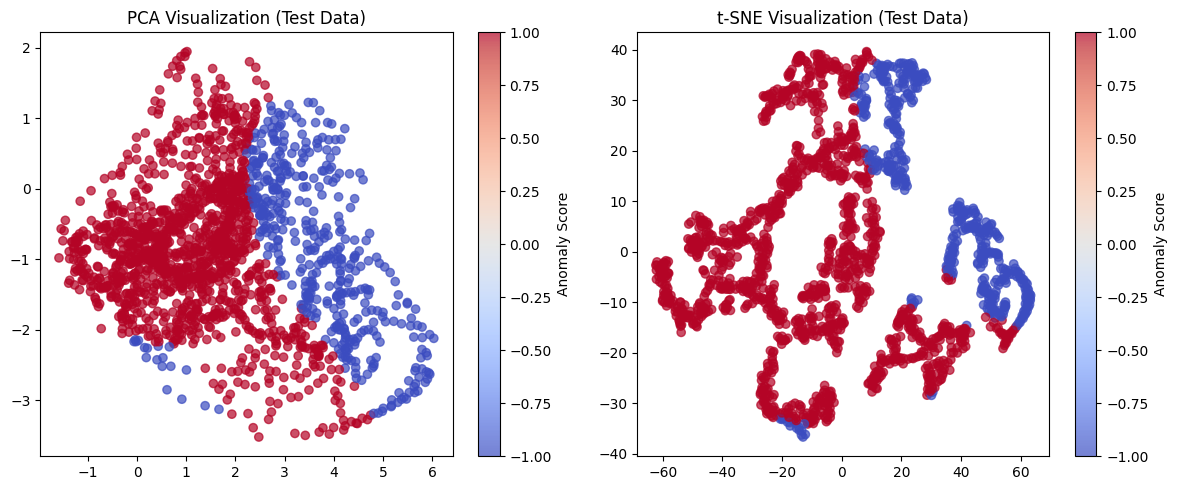

In [44]:
# Plot PCA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_anomaly_score, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly Score')
plt.title("PCA Visualization (Test Data)")

plt.subplot(1, 2, 2)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=test_anomaly_score, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly Score')
plt.title("t-SNE Visualization (Test Data)")

plt.tight_layout()
plt.show()

In [110]:
import plotly.graph_objects as go

# Plot time series dengan anomali
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=test_data.index,
    y=test_data['water_level'],
    mode='lines',
    name='Water Level',
    line=dict(color='blue')
))

# Highlight anomali
anomalies = test_data[test_data['anomaly'] == -1]
fig.add_trace(go.Scatter(
    x=anomalies.index,
    y=anomalies['water_level'],
    mode='markers',
    name='Anomaly',
    marker=dict(color='red', size=8)
))

fig.update_layout(
    title='Deteksi Anomali pada Data Water Level',
    xaxis_title='Timestamp',
    yaxis_title='Water Level (cm)'
)
fig.show()

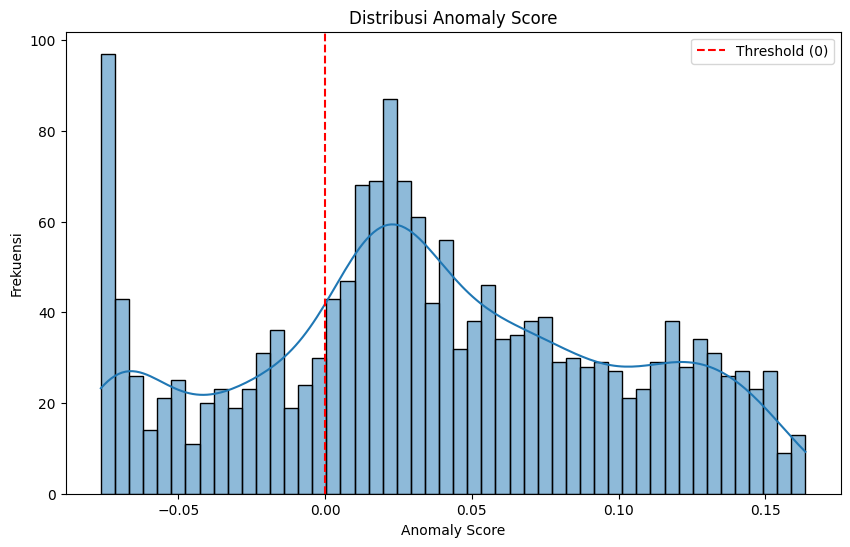

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(test_data['anomaly_score'], kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--', label='Threshold (0)')  # Default threshold Isolation Forest
plt.title('Distribusi Anomaly Score')
plt.xlabel('Anomaly Score')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()